In [326]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [327]:
df = pd.read_csv("taxi_weather.csv")
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,distance_traveled_km,week_day
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,3.13,0.50,0.0,0,72,57,17.231137,0
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,9.84,0.00,0.0,0,30,20,246.295936,1
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,4.92,0.07,0.0,0,83,67,55.251875,3
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,4.92,0.22,0.0,0,71,54,38.152003,5
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,4.47,0.00,0.0,0,61,44,74.122374,1


Drop the nans from the dataframe

In [328]:
df = df.dropna(axis='rows')
print('New number of observations: %d' % len(df))

New number of observations: 990845


A lot of the coordinates are wrong and would mess up the analysis, so first take those out of the df

After checking the coordinates against a map of NYC, I've determined that reasonable longitude bounds are [-74.20, -73.25] which reasonable latitude bounds are [40.95, 40.50].

In [329]:
# lower bound for latitude
df = df[df['pickup_latitude'] >= 40.5]
df = df[df['dropoff_latitude'] >= 40.5]

# upper bound for latitude
df = df[df['pickup_latitude'] <= 40.95]
df = df[df['dropoff_latitude'] <= 40.95]

# upper bound for longitude
df = df[df['pickup_longitude'] <= -73.75]
df = df[df['dropoff_longitude'] <= -73.75]

# lower bound for longitude
df = df[df['pickup_longitude'] >= -74.2]
df = df[df['dropoff_longitude'] >= -74.2]

Convert the lattitudes and longitudes to np arrays of x and y so that I can form a grid.

Divide the area up into grid of 100 by 100 rectangles

In [330]:
y = np.concatenate([df['pickup_latitude'].to_numpy(), df['dropoff_latitude'].to_numpy()])
x = np.concatenate([df['pickup_longitude'].to_numpy(), df['dropoff_longitude'].to_numpy()])

bottom_left, bottom_right = (x.min(), y.min()), (x.max(), y.min())
top_left, top_right = (x.min(), y.max()), (x.max(), y.max())

cols = np.linspace(bottom_left[0], bottom_right[0], num=100)
rows = np.linspace(bottom_left[1], top_left[1], num=100)


# create columns for each observation's dropoff and pickup places in the grid
df['pick_col'] = np.searchsorted(cols, df['pickup_longitude'])
df['drop_col'] = np.searchsorted(cols, df['dropoff_longitude'])

df['pick_row'] = np.searchsorted(rows, df['pickup_latitude'])
df['drop_row'] = np.searchsorted(rows, df['dropoff_latitude'])

Create a 2d histogram to visualize the densities of pickup and dropoff points

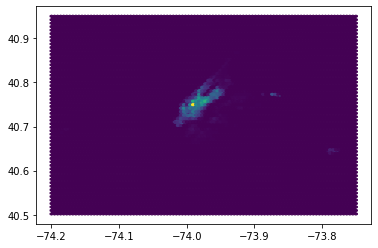

In [331]:
plt.hexbin(x,y)
plt.show()

In [332]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,DATE,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,distance_traveled_km,week_day,pick_col,drop_col,pick_row,drop_row
0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,3.13,0.50,0.0,0,72,57,17.231137,0,79,79,49,47
1,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,9.84,0.00,0.0,0,30,20,246.295936,1,41,49,47,62
2,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,4.92,0.07,0.0,0,83,67,55.251875,3,48,46,58,55
3,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,4.92,0.22,0.0,0,71,54,38.152003,5,47,46,52,57
4,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,4.47,0.00,0.0,0,61,44,74.122374,1,51,54,59,63


try plotting a subsection of these points since it seems like most of the boxes are relatively unused, effectively zooming in

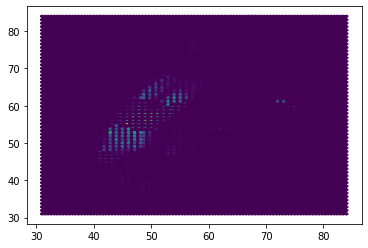

In [333]:
x_corr = np.concatenate([df['pick_col'].to_numpy(), df['drop_col'].to_numpy()])
y_corr = np.concatenate([df['pick_row'].to_numpy(), df['drop_row'].to_numpy()])

x_indexes = np.where((x_corr <= 30) | (x_corr >= 85))
y_indexes = np.where((y_corr <= 30) | (y_corr >= 85))

# get the unique index positions of the observations that don't fit to filter them out
indexes = np.unique(np.concatenate([x_indexes, y_indexes], axis=1))

# filter the x and y coordinates and then plot
x_fil = np.delete(x_corr, indexes)
y_fil = np.delete(y_corr, indexes)

plt.hexbin(x_fil,y_fil)
plt.show()

Now find the 100 most densely populated (x, y) pairs in the grid 

In [345]:
import collections

pair_occurances = collections.defaultdict(list)
for n in range(len(x_corr)):
    #pair = x_corr[n], y_corr[n]
    pair_occurances[n].append([x_corr[n], y_corr[n]])

result = [pair_occurances[key] for key in sorted(pair_occurances.keys(), reverse=True)]
top_100 = result[:100]

# remove nesting to get a list of the 100 most common pairs
top_100 = [n for item in top_100 for n in item]

Now that I have the 100 most common pairs, find all of the observations that fit inside them and use those for the analysis

In [386]:
# first reset the indexes so that I can iterate through the rows
df = df.reset_index(drop=True)

# find index positions of the observations with pickup or dropoff in the most common zones
df_indexes = []
top_100_indexes = []
for n in range(len(df)):
    if [df['pick_col'][n], df['pick_row'][n]] in top_100:
        df_indexes.append(n)
        top_100_indexes.append(top_100.index([df['pick_col'][n], df['pick_row'][n]]))
    elif [df['drop_col'][n], df['drop_row'][n]] in top_100:
        df_indexes.append(n)
        top_100_indexes.append(top_100.index([df['drop_col'][n], df['drop_row'][n]]))

In [388]:
len(top_100_indexes)

657782

create separate dataframes for observations in each of the top 100 zones

In [389]:
# list of dataframes
dfs = []

for i in range(len(df_indexes)):
    if [df.iloc[df_indexes[i]]['pick_col'], df.iloc[df_indexes[i]]['pick_row']] in top_100:
        
# for each of the top_100, 

SyntaxError: unexpected EOF while parsing (<ipython-input-389-4716c86f4f10>, line 1)

In [392]:
df.iloc[2]['drop_col']

46